In [113]:
import os
import pickle
from pathlib import Path
import sys
sys.path.append('../')
import pnstyler.styler as styling
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from kooplearn.datasets import LogisticMap
logistic = LogisticMap(N = 20, rng_seed=0)
from tabulate import tabulate

In [114]:
#Load and parse data results, final object with this schema {'model_name': {'feature_dim': [], 'hausdorff-dist': [], 'optimality-gap': [], ...}}
files = [f for f in os.listdir('results/')]
feature_dim = [int(f.split('_')[2].split('.')[0]) for f in files]
model_names = []
dicts = []
for f in files:
    with open('results/' + f, 'rb') as f:
        restored_dict = pickle.load(f)
        mname = restored_dict.pop('name')
        dicts.append(restored_dict)
        model_names.append(mname)
reports = {}
for idx, name in enumerate(model_names):
    d = dicts[idx]
    fdim = feature_dim[idx]
    if name not in reports:
        reports[name] = {}
    
    if 'feature_dim' not in reports[name]:
        reports[name]['feature_dim'] = []
    reports[name]['feature_dim'].append(fdim)
    for key, value in d.items():
        if key not in reports[name]:
            reports[name][key] = []
        reports[name][key].append(value)
#Sort by feature dim
for model_name, model_report in reports.items():
    sort_perm = np.argsort(model_report['feature_dim'])
    for k, v in model_report.items():
        ordered_v = [reports[model_name][k][i] for i in sort_perm]
        try:
            ordered_v = np.array(ordered_v)
        except:
            pass
        reports[model_name][k] = ordered_v

In [115]:
# Create tables for the report
feature_dims = [7] #Manually select the number of features to show in the table
model_order = ['DPNets', 'DPNets-relaxed', 'VAMPNets', 'Cheby-T', 'NoiseKernel']
columns = ['hausdorff-distance', 'optimality-gap']#, 'time_per_epoch']

table = np.zeros((len(model_order), len(columns)*len(feature_dims)), dtype = np.float64)
table_std = np.zeros_like(table)

for midx, model_name in enumerate(model_order):
    report = reports[model_name]
    for feat_idx, dim in enumerate(feature_dims):
        ftoid = np.where(report['feature_dim'] == dim)[0][0]
        for metric_idx, metric in enumerate(columns):
            col_idx = feat_idx*len(columns) + metric_idx
            if metric in report:
                val = report[metric][ftoid]
                if metric + '_std' in report:
                    if metric != 'time_per_epoch':
                        val_std = report[metric + '_std'][ftoid]
                    else:
                        val_std = np.inf
                else:
                    val_std = np.inf
            else:
                val = np.inf
                val_std = np.inf   
            table[midx, col_idx] = val
            table_std[midx, col_idx] = val_std

best_idx = np.argmin(table, axis = 0)
#Create the table
table_rows = []
for row_idx, model_name in enumerate(model_order):
    if row_idx <= 1:
        row = [f'\\textbf{{{model_name}}}']
    else:
        row = [model_name]
    for feat_idx, dim in enumerate(feature_dims):
        for metric_idx, metric in enumerate(columns):
            col_idx = feat_idx*len(columns) + metric_idx
            val = table[row_idx, col_idx]
            val_std = table_std[row_idx, col_idx]
            if row_idx == best_idx[col_idx]:
                if val == np.inf:
                    row.append(f'\\textbf{{-}}')
                else:
                    if val_std == np.inf:
                        row.append(f'\\textbf{{{val:.2f}}}')
                    else:
                        row.append(f'\\textbf{{{val:.2f}}} (\\textbf{{{val_std:.2f}}})')
            else:
                if val == np.inf:
                    row.append(f'-')
                else:
                    if val_std == np.inf:
                        row.append(f'{val:.2f}')
                    else:
                        row.append(f'{val:.2f} ({val_std:.2f})')
    table_rows.append(row)      

In [116]:
headers = [r"Representation",] +  len(feature_dims)*[ r"Spectral Error", r"Optimality Gap"]
colalign = ("right",) + len(feature_dims)*("center", "center")
print(tabulate(table_rows, headers= headers, tablefmt="latex_raw", colalign=colalign))

\begin{tabular}{rcc}
\hline
          Representation &        Spectral Error         &        Optimality Gap         \\
\hline
         \textbf{DPNets} &          0.30 (0.02)          & \textbf{0.64} (\textbf{0.01}) \\
 \textbf{DPNets-relaxed} & \textbf{0.06} (\textbf{0.05}) &          1.19 (0.04)          \\
                VAMPNets &          0.23 (0.11)          &          0.97 (0.22)          \\
                 Cheby-T &             0.20              &             1.24              \\
             NoiseKernel &             0.19              &             2.17              \\
\hline
\end{tabular}


In [117]:
def get_eigs(report):
    report = deepcopy(report)
    model_name = report.pop("name")
    feature_dims = []
    eigs = []
    for k, v in report.items():
        feature_dims.append(int(k.split('_')[0]))
        eigs.append(v['estimator-eigenvalues'])
    feature_dims = np.arange(len(report)) + 2
    return feature_dims, eigs, model_name

In [118]:
def pt_to_inch(pt):
    return pt/72.27

def figsize(wratio = 1, width_to_height = 3/2, text_width_pt = 397):
    w = pt_to_inch(text_width_pt)*wratio
    h = w/width_to_height
    return (w,h)

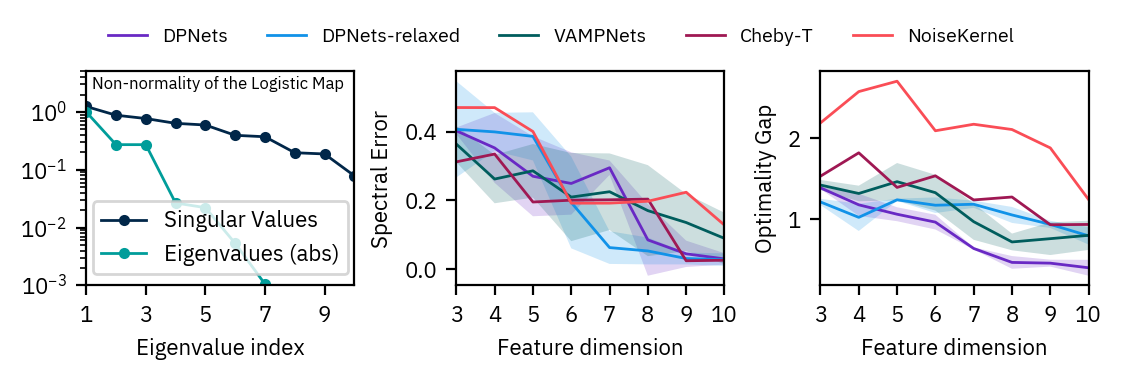

In [119]:
fig, axes = plt.subplots(1, 3, figsize = figsize(width_to_height=9/2.5), layout="constrained")
metric_name = ['Spectral Error', 'Optimality Gap']
metric_stub = ['hausdorff-distance', 'optimality-gap']


ax = axes[0]
ax.plot(np.arange(1, 22), logistic.svals(), '.-', color=styling.palettes['categorical_light'][-3], label= 'Singular Values')
ax.plot(np.arange(1, 22), np.abs(logistic.eig()), '.-', color=styling.palettes['categorical_light'][-4], label = 'Eigenvalues (abs)')
ax.set_yscale('log')
ax.set_xlabel("Eigenvalue index")
ax.set_ylim(1e-3, 5)
ax.set_xlim(1, 10)
ax.set_xticks([1, 3, 5, 7, 9])
ax.legend(loc='lower center')
ax.text(0.02, 0.98, "Non-normality of the Logistic Map", transform=ax.transAxes, ha='left', va='top', fontsize=6)


for model_name in model_order:
    x = reports[model_name]['feature_dim']
    for ax_idx, series in enumerate(metric_stub):
        ax = axes[ax_idx + 1]
        y = reports[model_name][series]
        dy = reports[model_name].get(series+"_std", 0)
        ax.plot(x, y, label=model_name)
        ax.fill_between(x, y - dy, y + dy, alpha=0.2)
        ax.set_xlabel("Feature dimension")
        ax.set_ylabel(metric_name[ax_idx])
        ax.set_xmargin(0)
        ax.set_xticks(np.arange(3, 11))

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=5, fontsize=7)
fig.savefig('figures/logistic_featuredim.pdf', bbox_inches='tight', dpi=300)

In [120]:
from pseudopy import NonnormalMeshgrid
import scipy.integrate
N = logistic.N
def alphas_mat_el(i: int, j: int):
    def pairing(x):
        return logistic.noise_feature_composed_map(
            x, i
        ) * logistic.noise_feature_composed_map(x, j)

    return scipy.integrate.quad(pairing, 0, 1)[0]

def betas_mat_el(i: int, j: int):
    def pairing(x):
        return logistic.noise_feature(x, i) * logistic.noise_feature(x, j)

    return scipy.integrate.quad(pairing, 0, 1)[0]

def koopman_el(i: int, j: int):
    def pairing(x):
        return logistic.noise_feature(x, i) * logistic.noise_feature_composed_map(x, j)

    return scipy.integrate.quad(pairing, 0, 1)[0]

K = np.array([[koopman_el(i, j) for j in range(N + 1)] for i in range(N + 1)])
psspectra = NonnormalMeshgrid(K, real_n = 200, imag_n = 200)

In [121]:
def fmt_fn(level):
    level_exp = str(int(np.round(np.log10(level), 0)))
    return f"$10^{{{level_exp}}}$" 
    
def plot_eigs(reports, feature_dim, level_exps, lim = 1):
    fig, ax = plt.subplots(figsize=(2, 2))  
    #Plot unit circle
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='k', lw=0.75)
    levels = [10**i for i in level_exps]
    contours = ax.contour(psspectra.Real, psspectra.Imag, psspectra.Vals, levels=levels, colors='k', linestyles='dashed', linewidths=0.25) 
    ax.clabel(contours, inline=1, fmt= fmt_fn, fontsize=8)
    for model_name in model_order:
        report = reports[model_name]
        ftoid = np.where(report['feature_dim'] == feature_dim)[0][0]
        eigs = report['estimator-eigenvalues'][ftoid]
        #print(f"{model_name} eigenvalues: {eigs}")
        ax.scatter(eigs.real, eigs.imag, s = 3, label = model_name, alpha=0.5)
    ax.scatter(logistic.eig().real, logistic.eig().imag, s= 5, marker='x', color='k', label = 'True eigenvalues')
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=3, fontsize=8)
    ax.set_aspect('equal')
    return fig, ax

/var/folders/hv/61b9_7692vs_qnbhp7fxkmfh0000gn/T/ipykernel_13554/81788556.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


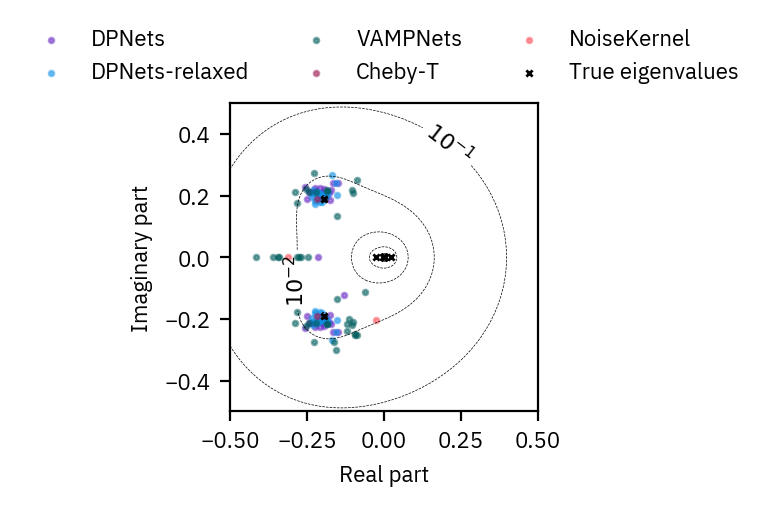

In [122]:
feature_dim = 9
fig, ax = plot_eigs(reports, feature_dim, level_exps = [-5, -4, -3, -2, -1], lim = 0.5)
fig.tight_layout()
#fig.savefig(f"figures/eigs_{feature_dim}_features.png")


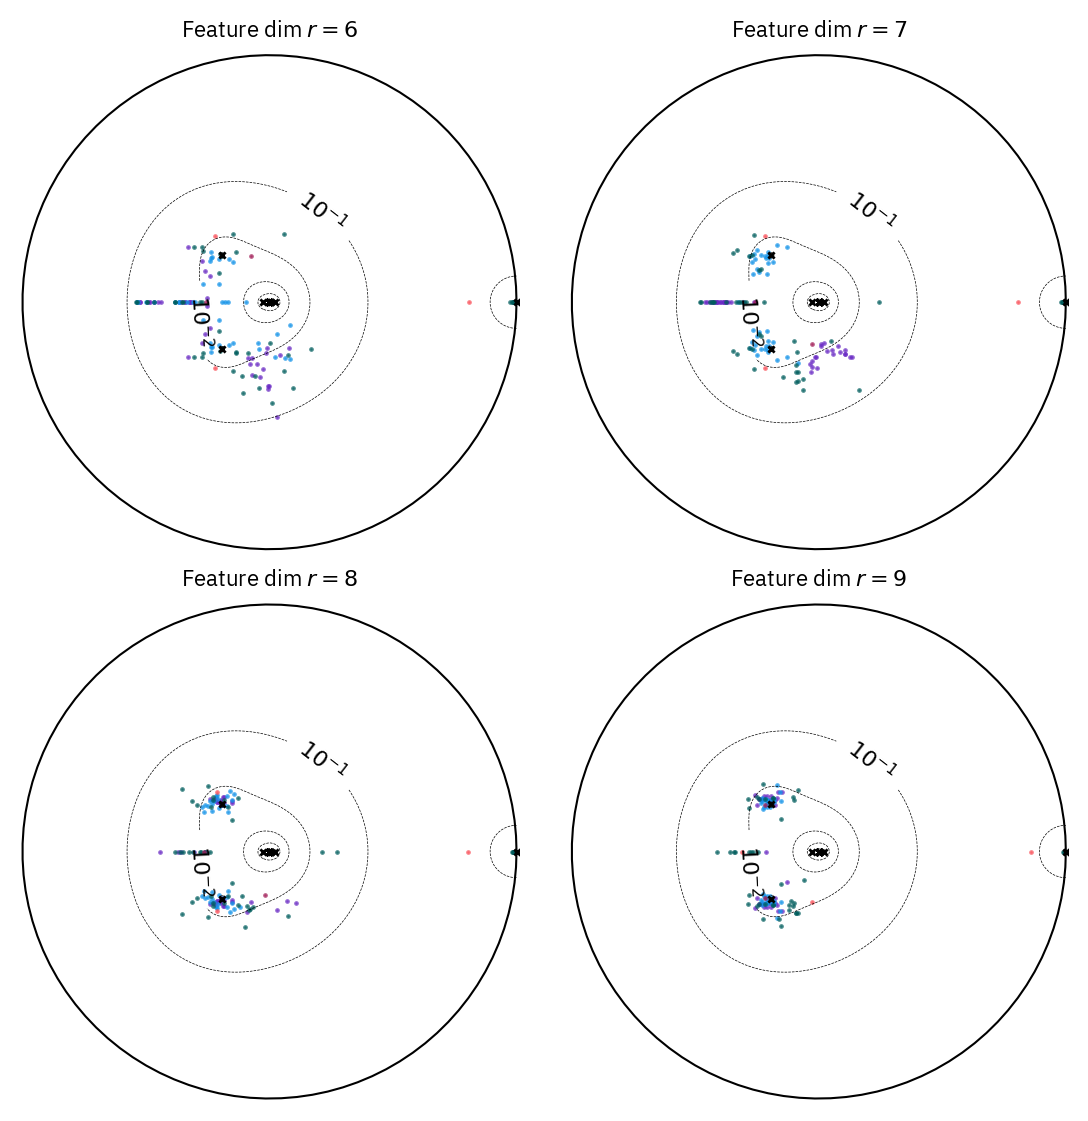

In [130]:
fig, axes = plt.subplots(2, 2, figsize = figsize(width_to_height=1), layout="constrained")

def plot_psspectra(ax, level_exps = [-5, -4, -3, -2, -1], lim = 1):
    #Plot unit circle
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='k', lw=0.75)
    levels = [10**i for i in level_exps]
    contours = ax.contour(psspectra.Real, psspectra.Imag, psspectra.Vals, levels=levels, colors='k', linestyles='dashed', linewidths=0.25) 
    ax.clabel(contours, inline=1, fmt= fmt_fn, fontsize=8)
    ax.scatter(logistic.eig().real, logistic.eig().imag, s = 5, marker='x', color='k', label = 'True eigenvalues')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=3, fontsize=8)
    ax.set_aspect('equal')
    return ax

feature_dims = [6, 7, 8, 9]
for ax_idx, ax in enumerate(axes.reshape(-1)):
    feature_dim = feature_dims[ax_idx]
    for model_name in model_order:
        report = reports[model_name]
        ftoid = np.where(report['feature_dim'] == feature_dim)[0][0]
        eigs = report['estimator-eigenvalues'][ftoid]
        #print(f"{model_name} eigenvalues: {eigs}")
        ax.scatter(eigs.real, eigs.imag, s = 0.5, label = model_name, alpha=0.7)
    ax = plot_psspectra(ax, lim = 1 + 1e-2)
    ax.axis('off')
    ax.set_title(f"Feature dim $r = {feature_dim}$", fontsize=8)
fig.savefig('figures/logistic_eigs.pdf', bbox_inches='tight', dpi=300)
#handles, labels = axes[1].get_legend_handles_labels()
#fig.legend(handles, labels, frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=6, fontsize=7)

MovieWriter imagemagick unavailable; using Pillow instead.


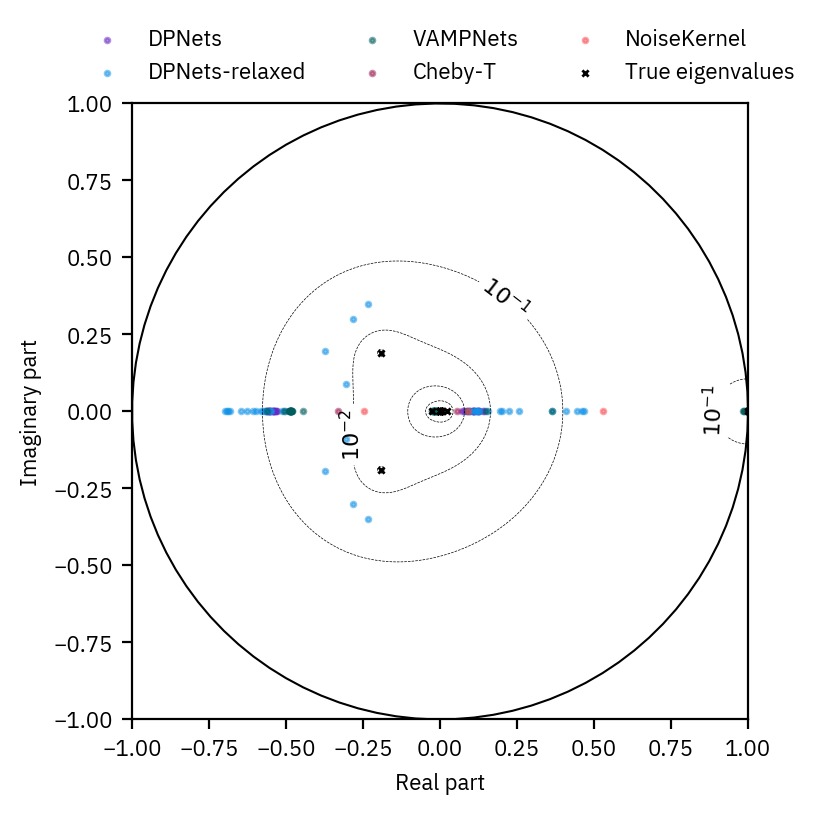

In [104]:
from matplotlib.animation import FuncAnimation
lim = 1
level_exps = [-5, -4, -3, -2, -1]
feature_dims = [3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots(figsize=(4, 4))  
#Plot unit circle
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), color='k', lw=0.75)
levels = [10**i for i in level_exps]
contours = ax.contour(psspectra.Real, psspectra.Imag, psspectra.Vals, levels=levels, colors='k', linestyles='dashed', linewidths=0.25) 
ax.clabel(contours, inline=1, fmt= fmt_fn, fontsize=8)
scatter_plots = []
feature_dim = feature_dims[0]
for model_name in model_order:
    report = reports[model_name]
    ftoid = np.where(report['feature_dim'] == feature_dim)[0][0]
    eigs = report['estimator-eigenvalues'][ftoid].flatten()
    sc = ax.scatter(eigs.real, eigs.imag, s = 3, label = model_name, alpha=0.5)
    scatter_plots.append(sc)
ax.scatter(logistic.eig().real, logistic.eig().imag, s= 5, marker='x', color='k', label = 'True eigenvalues')
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=3, fontsize=8)
ax.set_aspect('equal')

def update(frame): 
    feature_dim = feature_dims[frame]
    for midx, model_name in enumerate(model_order):
        report = reports[model_name]
        try:
            ftoid = np.where(report['feature_dim'] == feature_dim)[0][0]
            eigs = report['estimator-eigenvalues'][ftoid].flatten()
            scatter_plots[midx].set_offsets(np.c_[eigs.real, eigs.imag])
        except:
            pass

ani = FuncAnimation(fig, update, frames=np.arange(len(feature_dims)), interval=1000, repeat=True)
ani.save('figures/eigs.gif', dpi=200, writer='imagemagick')